`PyTorch` is an open source deep learning framework. Can use GPUs (think: VM).

Learn: tensors, syntax, autograd, training neural network via backprop.

`PyTorch` is meant to replace `numpy` so as to utilize GPUs.

In [1]:
import torch
import torchvision

ModuleNotFoundError: No module named 'torchvision'

The `tensor` is the fundamental array data structure, similar to `numpy.ndarray`.

In [4]:
from __future__ import print_function

In [15]:
x = torch.empty(5, 3) # full of garbage
x = torch.rand(5, 3)
x = torch.zeros(5, 3, dtype=torch.long)
x = torch.tensor([5.5, 3])
y = torch.randn_like(x, dtype=torch.double)

In [25]:
x.size() # returns a `torch.Size` object

torch.Size([2])

In [28]:
x = torch.ones(5, 3)
y = torch.randn_like(x)
x+y

tensor([[ 2.0580, -0.0134,  2.0279],
        [ 1.7451, -1.3204,  1.0627],
        [ 0.4354, -0.6677,  1.3324],
        [ 0.5372,  1.0997,  2.4126],
        [-0.3146,  1.6650,  1.4211]])

In [35]:
result = torch.empty_like(x)
torch.add(x,y, out=result) # specify output variable
y.add_(x) # in-place addition!

tensor([[ 3.0580,  0.9866,  3.0279],
        [ 2.7451, -0.3204,  2.0627],
        [ 1.4354,  0.3323,  2.3324],
        [ 1.5372,  2.0997,  3.4126],
        [ 0.6854,  2.6650,  2.4211]])

Mutator operations are post-fixed with an underscore, `_`.

Standard `numpy` array indexing applies here as well!

`torch.view` is used to resize or reshape a tensor.

In [39]:
x = torch.randn(1)
print(x)
print(x.item())

tensor([0.2293])
0.22925299406051636


It is easy to move between `numpy` structures and `torch` ones.

Tensors can be moved to various devices (i.e., GPUs) by using the `.to` method. Check if we have GPU support:

In [40]:
if torch.cuda.is_available():
    print("CUDA available")
else:
    print("Not available")

Not available


# Autodiff

When we create a tensor, we can set `.requires_grad` attribute to indicate whether or not to track the operations on it. Later, we can call `.backward()` to automatically compute gradients, which are collated into the `.grad` attribute. We can `.detach()` a tensor from computation history in order to prevent any further computations from being tracked.

An alternative is to wrap a block of code in `with torch.no_grad():`. We do this when we have a model with trainable parameters, which need `requires_grad=True`, but we don't need gradients.

`Tensor` and `Function` together comprise an acyclic computation graph (this is not how JAX works!!).

In [75]:
import torch 

In [76]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [77]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [78]:
print(y.grad_fn) # y is the result of an operation on a tensor

In [79]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


The `.requires_grad` changes a `Tensor`'s `requires_grad` flag in-place.

In [80]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True) # mutator!
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


Backpropagation is easy.

In [81]:
out.backward()

In [82]:
x.grad # d(out)/dx

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

Another example

In [84]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ -427.7986,  -563.0364, -1570.2129], grad_fn=<MulBackward0>)


In [85]:
v = torch.tensor([0.1, 1., 0.0001], dtype=torch.float)
y.backward(v) # pass the point to `backward`

In [87]:
print(x.grad) # d(y)/dx (v)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


In [88]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


Use `detach` to get a new `Tensor` with same data but not tracking gradients:

In [89]:
y = x.detach()
print(y.requires_grad)

False


# Neural Networks

Use `torch.nn` library. An `nn.Module` is a combination of layers and a `forward(input)` function which maps input to output (forward propagation).

* Define the network, including learnable weights (`Parameters`);
* Iterate over a data set of inputs, pushing each through the network;
* Compute the loss;
* Backpropagate to get gradients of parameters with respect to inputs;
* Perform gradient descent update.

In [283]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # allow Module to init

        # 1 input image channel, 6 output channels
        # 3x3 square convolution kernels
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # affine operation
        self.fc1 = nn.Linear(16 * 6 * 6, 120) # 6x6 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # max pooling over (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) # reshape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 

    def num_flat_features(self,x):
        size = x.size()[1:] # all dims except batch dim
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

We defined the forward function which ties together all of the layers into a cohesive model; the backward function is automatically defined via `autograd`.

In [284]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


The learnable params are in the `parameters()` attribute:

In [285]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) # size of .weight of conv1

10
torch.Size([6, 1, 3, 3])


In [286]:
inp = torch.randn(1, 1, 32, 32) # random 32x32 input
# batch, channel, xdim, ydim
out = net(inp)
print(out)

tensor([[-0.0522, -0.0528, -0.0848,  0.0954, -0.1181, -0.1370, -0.0721,  0.0389,
          0.0325, -0.0936]], grad_fn=<AddmmBackward>)


In [287]:
# zero out the gradient: buffer all params and backprops with random grads
net.zero_grad()
out.backward(torch.randn(1, 10))

### Note: `torch.nn` supports only mini-batches, not single samples

This is probably why we needed to pass in an array of shape `nSamples x nChannels x Height x Width`.

Use `input.unsqueeze(0)` to add a dummy batch dimension.

`nn` contains several popular loss functions


In [293]:
output = net(inp)
target = torch.randn(10) # dummy target
target = target.view(1, -1) 
criterion = nn.MSELoss() # loss fn

loss = criterion(output, target)
print(loss) # notice that it's tracking gradients

tensor(1.3349, grad_fn=<MseLossBackward>)


We can follow it in the backward direction, looking at `.grad_fn`. This shows a whole computation graph which contains all of the operations performed in forward propagation. When we call `loss.backward()`, this entire graph is differentiated w.r.t. the loss; all `Tensors` in the graph with `requires_grad=True` will have `.grad` tensor accumulated into the gradient.

In [297]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

Let's do backpropagation

In [298]:
net.zero_grad()

print("conv1.bias.grad pre-backward()")
print(net.conv1.bias.grad)

loss.backward()

print("conv1.bias.grad post-backward()")
print(net.conv1.bias.grad)

conv1.bias.grad pre-backward()
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad post-backward()
tensor([ 0.0062, -0.0085,  0.0237, -0.0038, -0.0091,  0.0132])


Weight update rule is `weight = weight - learning_rate * gradient`

In [302]:
# manual
lr = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * lr)

In [301]:
# built-in
import torch.optim as optim 

optimizer = optim.SGD(net.parameters(), lr=0.01)

# in training loop:
optimizer.zero_grad() # super important: set gradient buffers to zero manually
output = net(inp)
loss = criterion(output, target)
loss.backward()
optimizer.step() # This does the update!


## Vision example

In [307]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

AttributeError: module 'torch.jit' has no attribute '_script_if_tracing'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [226]:
import numpy as np
Np = 60
x = torch.tensor(1.*np.random.rand(Np)).view(-1,1)
y = torch.tensor(3.3 * x + 1.23).view(-1,1)
if True:
    y.add_(0.2 * torch.randn_like(y))

In [231]:
class LinReg(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinReg,self).__init__()
        self.linear_map = torch.nn.Linear(input_size, output_size)
        self.linear_map.weight.data.fill_(0.5)

    def forward(self, x):
        """Apply the linear map."""
        return self.linear_map(x)

model = LinReg(1,1)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [242]:
Ne = 1001
lr = torch.empty(Ne, requires_grad=False)
for epoch in range(1001):
    optimizer.zero_grad() # zero out the gradients
    oup = model(x.float())
    le = loss(oup, y.float())
    lr[epoch] = le
    # get gradients]
    le.backward()
    # take step
    optimizer.step()
    if (epoch) % 100 == 0:
        print(f"epoch: {epoch}, loss {le.item():.4}")

epoch: 0, loss 0.04415
epoch: 100, loss 0.04142
epoch: 200, loss 0.03935
epoch: 300, loss 0.03777
epoch: 400, loss 0.03658
epoch: 500, loss 0.03566
epoch: 600, loss 0.03497
epoch: 700, loss 0.03444
epoch: 800, loss 0.03404
epoch: 900, loss 0.03374
epoch: 1000, loss 0.03351


linear_map.weight, 3.251
linear_map.bias, 1.266


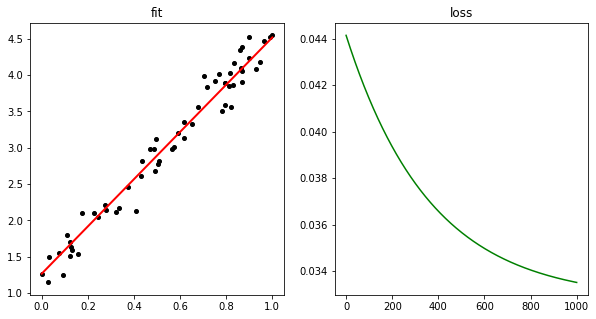

In [250]:
for n,p in model.named_parameters():
    if p.requires_grad:
        print(f"{n}, {p.data.item():.4}")

import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(10,5),ncols=2)

with torch.no_grad():

    xp = torch.linspace(0,1,50).view(-1,1)
    yp = model(xp)

    ax[0].plot(xp,yp, 'r', lw=2)
    ax[0].scatter(x,y, c='k', s=16, marker='o')
    ax[0].set(title="fit")
    ax[1].plot(lr.detach().numpy(), c='g')
    ax[1].set(title="loss")

    plt.show()

This is doing it like a network. Can we do it just directly, but while also using autograd?

In [276]:
import numpy as np
Np = 60
x = torch.from_numpy(1.*np.random.rand(Np)).view(-1,1)
y = (3.3 * x + 1.23).view(-1,1)
if True:
    y.add_(0.2 * torch.randn_like(y))
lr = 0.01

w = torch.autograd.Variable(torch.randn(1), requires_grad=True)
b = torch.autograd.Variable(torch.randn(1), requires_grad=True)

# optimizer = torch.optim.Adam([w,b])

def model(x, w, b):
    return b + x * w

def mse_loss(y_pred, y_true):
    return torch.sum((y_pred-y_true) ** 2)

for epoch in range(100):
    # optimizer.zero_grad()
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    outputs = model(x, w, b)
    loss = mse_loss(outputs, y)

    loss.backward() # compute grads of this 
    # changes state

    w -= lr * w.grad.data
    b -= lr * b.grad.data



AttributeError: 'NoneType' object has no attribute 'data'

In [281]:
loss

tensor(217.3257, dtype=torch.float64, grad_fn=<SumBackward0>)

# Neural networks